# <u> Data Science Capstone project: battle of the neighborhoods</u>
### Connor Ruch

## Introduction/Business Problem

- Define a problem or an idea where i would need to leverage the Foursquare location data to solve or execute
- Lets say that a mechanic wants to open a new shop in the DC area. If he could know where there would be demand for a new shop and no too much other competition he could pick that area.
- I plan to use the foursquare location data to get locations of all mechanics in the Washington, DC area. I will leverage this data to predict where the prosctive business owner could open a new shop. 
- If i can find a location with crashes and few mechanics it might be a sign that there is demand for a new shop at that area. 
- my steakholders would be any mechanics looking to open a new shop.

## Data Used


- this report will use the foursquare API to get location data for all mechanics in the DC area
- I will also be using a dataset of vehicle crashses in the Washington, DC area. The data was downloaded from Kaggle at this url : "https://www.kaggle.com/gauravduttakiit/accidents-in-washington-dc"

In [179]:
# import libraries
import pandas as pd
import numpy as np
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import folium
print("libraries imported successfully")

libraries imported successfully


In [180]:
# use geolocator to get coordinates
address = 'Washington, DC'

geolocator = Nominatim(user_agent='test_proj')
location = geolocator.geocode(address)
lat = location.latitude
long = location.longitude
print("Coordinates for Washington, DC: {}, {}".format(lat, long))

Coordinates for Washington, DC: 38.8949924, -77.0365581


In [181]:
# The code was removed by Watson Studio for sharing.

credentials set


In [182]:
search_query = ['auto', 'mechanic'] #changed to blank
radius = 3000
print(search_query)

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}\
&query={}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET, lat, long,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)

results = requests.get(url).json()

['auto', 'mechanic']


In [183]:
venues = results['response']['venues']
df = json_normalize(venues)

c:\users\jiminey\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [187]:
print(df.shape)
#print(df.name[:50].sort_values())
#df['categories'] = df['categories'].astype()

filtered_cols = ['name', 'categories'] + [col for col in df.columns if col.startswith('location.')] + ['id']

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
df_filtered = df.loc[:,filtered_cols]
df_filtered['categories'] = df_filtered.apply(get_category_type, axis=1)


df_filtered = df_filtered[['name', 'categories', 'location.lat' ,'location.lng', 'location.postalCode']]
df_filtered.head()
#print(df.groupby(by='categories').count())


(43, 19)


name categories  location.lat  location.lng  \
0              Auto Alliance       None     38.902200    -77.033240   
1              Auto Alliance     Office     38.900070    -77.021512   
2  Automated Graphic Imaging       None     38.905868    -77.032239   
3  Auto Ching Ching Mercedes       Road     38.905593    -77.043451   
4         Exotic Auto Detail   Car Wash     38.904973    -77.048837   

  location.postalCode  
0               20005  
1                 NaN  
2               20005  
3               20001  
4               20037

## Methodology
- Here i will use the folium package to visualize the data and plot where the mechanics and the crashes are
- Then i will cluster the crash data evenly using the KMeans algorithm.
- From there i will go about calulating the distance of each mechanic to the nearest cluster and assign the mechanic to the nearest cluster
- Then i will analyze the data in order to see if there is a area covered by a cluster that has a lower amount of mechanics.

In [188]:
#Plot the mechanics shops first
venues_map = folium.Map(location=[lat, long], zoom_start=13) 

folium.CircleMarker(
    [lat, long],
    radius=10,
    popup='Ecco',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(venues_map)

for lati, lng, label in zip(df_filtered['location.lat'], df_filtered['location.lng'], df_filtered.categories):
    folium.CircleMarker(
        [lati, lng],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(venues_map)

# display map
venues_map

- Below I will find the limits to set on the crash data in order to narrow the data down to only crashes in the same radius as the mechanics search

In [189]:
dc_crash_df = pd.read_csv("Washington_accidents.csv")

latitudes = []
for lat, long, label in zip(dc_crash_df['Start_Lat'], dc_crash_df['Start_Lng'], dc_crash_df['ID']):
    temp_dic = {}
    if lat > 38.93 or lat < 38.85:
        pass 
    else:
        if long > -77.01 or long < -77.06:
            pass
        else:
            temp_dic['ID'] = label
            temp_dic['lat'] = lat
            temp_dic['long'] = long
    if temp_dic:
        latitudes.append(temp_dic)
    
#print(latitudes)
dc_df = pd.DataFrame(latitudes)
print(dc_df.shape)
dc_df.sort_values(by='lat', ascending=True).head()

(1426, 3)


ID        lat       long
805   A-2575025  38.872988 -77.042354
1189  A-3309587  38.873060 -77.042273
991   A-2884633  38.873160 -77.042170
975   A-2871809  38.873160 -77.042170
974   A-2871799  38.873160 -77.042170

- Now time to plot the crashes as well.

In [190]:
for lati, lng, label in zip(dc_df['lat'], dc_df['long'], dc_df['ID']):
    folium.CircleMarker(
        [lati, lng],
        radius=2,
        popup=label,
        fill=True,
        color='green',
        fill_color='green',
        fill_opacity=0.6
        ).add_to(venues_map)

# display map
venues_map

 - I will now cluster the crashes, then analyze the foursquare data on mechanics to assign the data points to the nearest cluster of crashes

In [159]:
!pip install scikit-learn

You should consider upgrading via the 'c:\users\jiminey\appdata\local\programs\python\python36-32\python.exe -m pip install --upgrade pip' command.


In [191]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
print("library imported")

library imported


In [192]:
kclusters = 5

dc_df = dc_df.drop('ID', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dc_df)
kmeans.labels_[0:10]

array([4, 1, 3, 1, 1, 1, 3, 4, 1, 1])

In [193]:
dc_df.insert(0, 'Cluster Labels', kmeans.labels_)
dc_df.head()

Cluster Labels        lat       long
0               4  38.888493 -77.052330
1               1  38.882065 -77.027855
2               3  38.894791 -77.014091
3               1  38.879242 -77.035889
4               1  38.882214 -77.028603

In [194]:
# create map
map_clusters = folium.Map(location=[lat, long], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lati, lon, cluster in zip(dc_df['lat'], dc_df['long'], dc_df['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lati, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

- Now combine the 2 maps to show the mechanics within the clusters
- The crashes will appear with a white fill and the mechanics with a black fill

In [195]:
# create map
map_clusters = folium.Map(location=[lat, long], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lati, lon, cluster in zip(dc_df['lat'], dc_df['long'], dc_df['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lati, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color='white',
        fill_opacity=0.7).add_to(map_clusters)

for lati, lng, label in zip(df_filtered['location.lat'], df_filtered['location.lng'], df_filtered.categories):
    folium.CircleMarker(
        [lati, lng],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='black',
        fill_opacity=0.6
        ).add_to(map_clusters)

# display map
map_clusters

- df_filtered holds values for mechanics
- dc_df holds values for the crashes
- I need to map the mechanics to the clusters now and get a measure for how many mechanics are in each cluster. I can calculate the distance of each mechanic to each cluster. I can calulate by getting the square root of each lat, long to the power of 2 in order to noramlize before comparing distances. This will impose a reference frame on both sets of data allowing comparison of distances.

- First i need to clean the data a bit more which is shown below



In [196]:
crash_mean_df = dc_df.groupby('Cluster Labels').mean()
#use pythagorean theorum to calculate distance to origin in the lat, long reference frame, 
# I will then do the same for the mechanics to compare gemoetric distances
crash_mean_df['dist_from_ref'] = ((crash_mean_df['lat']**2) + (crash_mean_df['long']**2))**.05
crash_mean_df.reset_index(inplace=True)
crash_mean_df = crash_mean_df.sort_values('dist_from_ref')
crash_mean_df

Cluster Labels        lat       long  dist_from_ref
3               3  38.885963 -77.018408       1.561673
2               2  38.905856 -77.019850       1.561692
1               1  38.879897 -77.035208       1.561695
4               4  38.893569 -77.050492       1.561731
0               0  38.915929 -77.042112       1.561736

In [198]:
df_filtered['cluster'] = ''
df_filtered = df_filtered.dropna(subset=['location.postalCode'])
df_filtered.head()

name        categories  location.lat  location.lng  \
0              Auto Alliance              None     38.902200    -77.033240   
2  Automated Graphic Imaging              None     38.905868    -77.032239   
3  Auto Ching Ching Mercedes              Road     38.905593    -77.043451   
4         Exotic Auto Detail          Car Wash     38.904973    -77.048837   
6  Auto Insurance Washington  Insurance Office     38.914553    -77.017018   

  location.postalCode cluster  
0               20005          
2               20005          
3               20001          
4               20037          
6               20001

- The code below calculates the nearest cluster center to each mechanic and then assigns that cluster to the mechanic in the "df_filtered" dataframe

In [199]:
#dist_diff_list = []
for latit, longit, index in zip(df_filtered['location.lat'], df_filtered['location.lng'], df_filtered.index):
    #get distance from mechanic to each cluster average and see which is nearest.
    dp_mech = ((latit**2) + (longit**2))**.05
    nearest_clust = -1 #if any turn up -1 then i know it wasnt assigned correctly
    temp_dict = {}
    for dist, cluster in zip(crash_mean_df['dist_from_ref'], crash_mean_df['Cluster Labels']):
        dist_diff = dist - dp_mech
        dist_diff = dist_diff**2 #this will eliminate negatives as I want abosulte distance and the ratio is all that matters
        temp_dict[dist_diff] = cluster
    sorted_dist_list = temp_dict.keys()
    sorted_dist_list = sorted(sorted_dist_list)
    nearest_clust = temp_dict[sorted_dist_list[0]] #this will get first value which should be nearest cluster label
    df_filtered['cluster'][index] = nearest_clust
   


c:\users\jiminey\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [200]:
# lets see the df with the mechanics and drop values with no postal code so we can see 
df_filtered.head()

name        categories  location.lat  location.lng  \
0              Auto Alliance              None     38.902200    -77.033240   
2  Automated Graphic Imaging              None     38.905868    -77.032239   
3  Auto Ching Ching Mercedes              Road     38.905593    -77.043451   
4         Exotic Auto Detail          Car Wash     38.904973    -77.048837   
6  Auto Insurance Washington  Insurance Office     38.914553    -77.017018   

  location.postalCode cluster  
0               20005       1  
2               20005       1  
3               20001       4  
4               20037       0  
6               20001       1

- The code below will show the mechanics frame after they have been assigned to clusters and a count by cluster
- This should show whether any cluster has too few mechanics.

In [201]:
count_frame = df_filtered.groupby('cluster').count()
count_frame

name  categories  location.lat  location.lng  location.postalCode
cluster                                                                   
0           9           8             9             9                    9
1           7           5             7             7                    7
2           6           6             6             6                    6
3           5           5             5             5                    5
4           8           8             8             8                    8

## Results

- We can see from the analysis that cluster 3 had the fewest mechanics within it. 
- If this data report can be used accuratly then it may be a good area to open a new shop in the DC area. 

In [202]:
count_frame.reset_index(inplace=True)
plotting_filter = count_frame[['cluster', 'name']]
plotting_filter = plotting_filter.rename(columns={"cluster": "Cluster", "name" : "Mechanic Count"})
plotting_filter

Cluster  Mechanic Count
0        0               9
1        1               7
2        2               6
3        3               5
4        4               8

- The Bar chart below shows the distribution of mechanics in the various clusters. 
- We can see again the cluster 3 had the fewest mechanics in the area which implies a better spot for a new shop

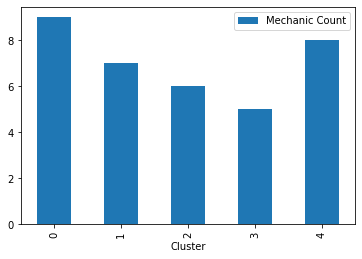

In [203]:
bar_chart = plotting_filter.plot.bar(x='Cluster', y='Mechanic Count')
bar_chart

- Looking again at the map, it shows cluster 3 (appearing in light green) would seem to be the best place for a new shop, down in southeastern DC. and cluster 0 (appearing in red) had the most shops, this could mean stiff competion for the new owner.

In [204]:
map_clusters

## Discussion

- Some observations: 
     - Cluster 3 seemed to be the best place for a new shop given that there were few other mechanics in the area despite a similar cluster of crashes.
     - Cluster 0 had the most mechanics in the area followed by cluster 4. It would seem these areas would have the most competition from competing shops.
     - Given that it probably takes a lot more analysis to probably determine the best place for a new shop, some more data and analysis could be done in order to figure out more about the market for auto maintenance
- Recomendations:
    - to a new business owner that he consider the analysis and given the other shops in the area that he open a shop in the geographic zone covered by cluster 0 (in light green) if possible

## Conclusion

- In conclusion the data seems to show some area for a new shop to be opened in DC. 
- It is very difficult to determine as a certainty what the market demand is for a new shop just based on the crash data.

- Certainly more analysis could be done, especially to analyze some of the assumptions in the report
- Some assumptions made include:
    - That in the event of a crash the car(s) would be most likely taken to the nearest mechanic in the area and,
    - That the prime business for a mechanic is derived from motor vehicle accidents. 
    
- There may be far more variables that determine the success of a mechanic shop but it is out of the scope of this report.
- Some other factors for shop success may include:
    - Number of residents in the area who own a vehicle,
    - Regulations by the state required auto inspection which may lead to more business for a shop, 
    - Average amount of vehicle care in the area compared to other areas, etc.

- Again more analysis should be done when deciding to open a new business but this showed some promise in analyzing the potential for demand and competition!

#### Author: Connor Ruch